# Softmax

Simple 1D softmax classifier model. Includes support for:

- Training on minibatches of training examples at a time
- Finite difference gradient checking
- Regularization

In [1]:
from collections import namedtuple

Model = namedtuple('Model', ['ws', 'bs', 'dws', 'dbs', 'loss'])
State = namedtuple('State', ['loss', 'dws', 'dbs'])

In [2]:
def softmax(scores):
    """Compute the softmax between two numbers
    
    s1 is the number we're finding the softmax of
    
    """
    e_x = np.exp(scores)
    
    return e_x / e_x.sum()

In [50]:
class Softmax:
    """Initialize model parameters
    
    Additionally calculate batch index so we can use minibatches with each training iteration
    
    """
    def __init__(self, xs_train=1, ys_train=1, ws=None, bs=None, learning_rate=0.001, batch_size=None):
        self.m = len(xs_train)
        
        self.xs_train, self.ys_train = xs_train, ys_train
        self.ws, self.bs = np.array([50.,65.]), np.array([100.,150.])
        
        self.learning_rate = learning_rate
        
        self.batch_size = self.m if not batch_size else batch_size
        self.batch_index = 0
        
    def forward_backward_prop(self, ws=None, bs=None):
        """Perform forward and backward prop over a minibatch of training examples
        
        Returns loss and gradients
        
        """
        ws = self.ws if not type(ws) == np.ndarray else ws
        bs = self.bs if not type(bs) == np.ndarray else bs
        
        loss, dws, dbs = 0., np.array([0.,0.]), np.array([0.,0.])
        lower, upper = self.batch_index*self.batch_size, (self.batch_index+1)*self.batch_size
        for x, y in zip(self.xs_train[lower:upper], self.ys_train[lower:upper]):
            # Forward propagation
            scores = np.array([x,x])*ws + bs
            probs = softmax(scores)

            # Accumulate loss
            loss += -np.log(probs[y])

            # Backpropagate to accumulate dbs and dws
            dloss = 1
            dscores = probs
            dscores[y] -= 1
            dbs += dscores
            dws += x * dscores
        
        return State(loss/self.m, dws/self.m, dbs/self.m)
    
    def step(self):
        """Run one iteration of gradient descent with a minibatch of training examples"""
        
        loss, dws, dbs = self.forward_backward_prop()
        
        self.ws = self.ws - self.learning_rate*dws
        self.bs = self.bs - self.learning_rate*dbs
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.m//self.batch_size)
                
        return Model(self.ws, self.bs, dws, dbs, loss)

## Run it!

In [36]:
from data.softmax import xs_train, ys_train

sm = Softmax(xs_train, ys_train, learning_rate=0.01, batch_size=2)

def estimates(iters):
    for _ in range(iters):
        yield sm.step()
        
estimates = list(estimates(5000))

## How Does the Model Evolve Over Time?

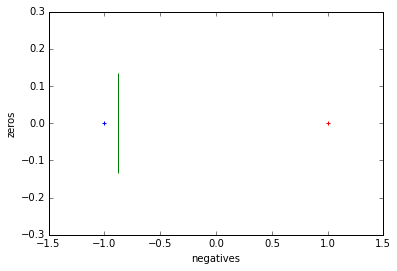

In [37]:
from ipywidgets import interact, fixed

@interact(xs_train=fixed(xs_train), ys_train=fixed(ys_train), view_index=(0, len(estimates)), estimates=fixed(estimates))
def plot(xs_train, ys_train, view_index, estimates):
    ws, bs, _, _, _ = estimates[view_index]
    
    # Get data into suitable form for plotting
    positives, negatives = xs_train[:len(xs_train)//2], xs_train[len(xs_train)//2:]
    df1 = pd.DataFrame({'positives': positives, 'negatives': negatives, 'zeros': np.zeros_like(positives)})
    
    # Solve for the decision boundary
    decision = (bs[1]-bs[0]) / (ws[0]-ws[1])
    
    ys = np.linspace(-.001,.001)
    df2 = pd.DataFrame({'x': [decision], 'y': [0]})
    
    axes = df2.plot(kind='scatter', x='x', y='y', color='g', marker='|', s=10000)
    axes = df1.plot(ax=axes, kind='scatter', x='positives', y='zeros', color='r', marker='+')
    df1.plot(ax=axes, kind='scatter', x='negatives', y='zeros', color='b', marker='+')

## Finite Difference Gradient Check

In [53]:
def numerical_gradients(f, ws, bs):
    """Compute numerical gradients of f with respect to w and b
    
    Returns approximation for df/dw and df/db
    
    """
    dws, dbs = np.zeros_like(ws), np.zeros_like(bs)
    h = np.zeros_like(ws)
    step = 0.00001
    
    # df/dw1 and df/db1
    h[0] = step
    dws[0] = (f(ws+h, bs)  -f(ws-h, bs))   / (2*step)
    dbs[0] = (f(ws,   bs+h)-f(ws,   bs-h)) / (2*step)
    h[0] = 0
    
    # df/dw1 and df/db1
    h[1] = step
    dws[1] = (f(ws+h, bs)  -f(ws-h, bs))   / (2*step)
    dbs[1] = (f(ws,   bs+h)-f(ws,   bs-h)) / (2*step)
    h[1] = 0
    
    return dws, dbs

## Run Through a Few Iterations and Assert Analytic and Numerical Gradients are Close

In [58]:
sm = Softmax(xs_train, ys_train)

for _ in range(10):
    # Analytic gradient computed via backprop
    _, analytic_dws, analytic_dbs = sm.forward_backward_prop()
    
    # Numerical gradient compute via twiddling w and b and inspecting loss
    numerical_dws, numerical_dbs = numerical_gradients(lambda ws, bs: sm.forward_backward_prop(ws, bs).loss, sm.ws, sm.bs)
    
    # Compute relative error
    dws_error = abs(numerical_dws - analytic_dws) / (abs(numerical_dws) + abs(analytic_dws))
    dbs_error = abs(numerical_dbs - analytic_dbs) / (abs(numerical_dbs) + abs(analytic_dbs))
    
    try:
        assert(np.linalg.norm(dws_error) < 1e-6 and np.linalg.norm(dbs_error) < 1e-6)
    except AssertionError:
        warn(dws_error)
        warn(dbs_error)
        
else:
    print('Gradient check passed!')

Gradient check passed!
